In [1]:
import io
import subprocess
import os
import glob
import sys
import pwd

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings
import statsmodels.stats.multitest as smm
import json

from pathlib import Path
from midas import m
from datetime import datetime, date
import altair as alt
from pathlib import Path
#from midas import m
#from datetime import datetime, date
#import altair as alt

# gh specific
sys.path.append('/ghsfa/projects/pharma/shared_scripts/')
import bibp.functions as functions
import hgvslib.pHGVS as pHGVS  ## do a pull on the hgvslib git repo

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/XTX_TFv2_update_Batch1to40_01162025"

# XTX TFv2 update (any batch run with BIP version before 1.6.1)

## Data preocessing

In [2]:
# Delivered batches that received before 11/15/2024. Folder was shared by Brittany
folder_path = f"{work_dir}/XTX_01_SOW01_Infinity_01_to_39"

# List to store the dataframes and path
dfs = []
pathes = []
files_with_BIP161 = []

# Iterate through all subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            pathes.append(file_path)
            try:
                # Read the CSV file
                df = pd.read_csv(file_path, header=0)
                dfs.append(df)
                # # Identify the batch that used Sirius 1.6.1, the list is from later step
                # if df['GHSampleID'].isin(samples_BIP161_list).any():
                #     files_with_BIP161.append(file_path)
            except pd.errors.ParserError:
                print(f"Error reading file: {file_path} - possibly incorrect header.")
            except Exception as e:
                print(f"An unexpected error occurred with file: {file_path} - {str(e)}")

# Concatenate all dataframes into one final dataframe
df_xtx = pd.concat(dfs, ignore_index=True)

print("Total batch # of XTX is " + str(len(pathes)) + "\n") 
print("Total sample size of XTX is " + str(df_xtx.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of XTX is " + str(df_xtx.Patient_ID.nunique()) + "\n")

df_xtx.head()

Total batch # of XTX is 39

Total sample size of XTX is 46

Total unique patient sample size of XTX is 35



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,XTX101-0102-001,NaN,A1163194,B00780425,140-002,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.029876,14.89,4.5,NaN,9/28/24,9/27/24,10/15/24
1,XTX101-0102-001,NaN,A1163461,B00780719,140-001,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.001860,63.07,4.5,NaN,9/28/24,9/27/24,10/15/24
2,XTX101-0102-001,NaN,A1149848,B00767105,104-016,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.123297,209.07,3.5,NaN,9/14/24,9/13/24,9/27/24
3,XTX101-0102-001,NaN,A1159882,B00777818,106-004,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.016733,14.89,4.0,NaN,9/25/24,9/24/24,10/15/24
4,XTX101-0102-001,NaN,A1182327,B00802830,140-002,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.012436,24.29,3.5,NaN,10/19/24,10/18/24,11/6/24


In [4]:
# Delivered batches that received after 11/15/2024. I pulled all the file individually by 01/23/2025
folder_path = f"{work_dir}/XTX_161"

# List to store the dataframes and path
dfs = []
pathes = []
# files_with_BIP161 = []

# Iterate through all subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            pathes.append(file_path)
            try:
                # Read the CSV file
                df = pd.read_csv(file_path, header=0)
                dfs.append(df)
                # # Identify the batch that used Sirius 1.6.1, the list is from later step
                # if df['GHSampleID'].isin(samples_BIP161_list).any():
                #     files_with_BIP161.append(file_path)
            except pd.errors.ParserError:
                print(f"Error reading file: {file_path} - possibly incorrect header.")
            except Exception as e:
                print(f"An unexpected error occurred with file: {file_path} - {str(e)}")

# Concatenate all dataframes into one final dataframe
df_xtx_new = pd.concat(dfs, ignore_index=True)

print("Total batch # of XTX is " + str(len(pathes)) + "\n") 
print("Total sample size of XTX is " + str(df_xtx_new.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of XTX is " + str(df_xtx_new.Patient_ID.nunique()) + "\n")

df_xtx_new.head()

# Save the data to evalute CRC caller region file bug in Sirius 1.6.x
df_xtx_new.to_csv(f"{work_dir}/df_xtx_Sirius161.csv", index = False)


Total batch # of XTX is 42

Total sample size of XTX is 42

Total unique patient sample size of XTX is 32



In [2]:
# Latest XTX batches
# folder_path = f"{work_dir}/XTX_01292025to01312025"
# folder_path = f"{work_dir}/XTX_02042025to02062025"
# folder_path = f"{work_dir}/XTX_02202025"
# folder_path = f"{work_dir}/XTX_02262025"
folder_path = f"{work_dir}/All_CRC_flipped_samples_reanalysize_by03062025"


# List to store the dataframes and path
dfs = []
pathes = []
# files_with_BIP161 = []

# Iterate through all subfolders in the main folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            pathes.append(file_path)
            try:
                # Read the CSV file
                df = pd.read_csv(file_path, header=1)
                dfs.append(df)
                # # Identify the batch that used Sirius 1.6.1, the list is from later step
                # if df['GHSampleID'].isin(samples_BIP161_list).any():
                #     files_with_BIP161.append(file_path)
            except pd.errors.ParserError:
                print(f"Error reading file: {file_path} - possibly incorrect header.")
            except Exception as e:
                print(f"An unexpected error occurred with file: {file_path} - {str(e)}")

# Concatenate all dataframes into one final dataframe
df_xtx_new = pd.concat(dfs, ignore_index=True)

print("Total batch # of XTX is " + str(len(pathes)) + "\n") 
print("Total sample size of XTX is " + str(df_xtx_new.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of XTX is " + str(df_xtx_new.Patient_ID.nunique()) + "\n")

df_xtx_new.head()

# Save the data to evalute CRC caller region file bug in Sirius 1.6.x
# df_xtx_new.to_csv(f"{work_dir}/df_xtx_Sirius161_01312025.csv", index = False)
# df_xtx_new.to_csv(f"{work_dir}/df_xtx_Sirius161_02062025.csv", index = False)
# df_xtx_new.to_csv(f"{work_dir}/df_xtx_Sirius161_02202025.csv", index = False)
df_xtx_new.to_csv(f"{work_dir}/df_xtx_Sirius161_03062025.csv", index = False)



Total batch # of XTX is 7

Total sample size of XTX is 7

Total unique patient sample size of XTX is 5



In [7]:
# Print out batches from 1-40 that run with 1.6.1 which do not need to be re-analyzed
files_with_BIP161

['/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/XTX_TFv2_update_Batch1to40_01162025/XTX_01_SOW01_Infinity_01_to_39/XTX_SOW01_Infinity_28/20241127_XilioTherapeutics_SOW01_Batch28_1Samples_MonitoringReport.csv',
 '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/XTX_TFv2_update_Batch1to40_01162025/XTX_01_SOW01_Infinity_01_to_39/XTX_SOW01_Infinity_36/20241203_XilioTherapeutics_SOW01_Batch36_1Samples_MonitoringReport.csv',
 '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/XTX_TFv2_update_Batch1to40_01162025/XTX_01_SOW01_Infinity_01_to_39/XTX_SOW01_Infinity_27/20241127_XilioTherapeutics_SOW01_Batch27_1Samples_MonitoringReport.csv',
 '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/XTX_TFv2_update_Batch1to40_01162025/XTX_01_SOW01_Infinity_01_to_39/XTX_SOW01_Infinity_38/20241203_XilioTherapeutics_SOW01_Batch38_1Samples_MonitoringReport.csv',
 '/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/XTX_TFv2_update_Batch1to40_

In [3]:
# SQL query for pulling the XTX sample fron GHDB
query = """
SELECT *
FROM gh_sample
WHERE 
      project = 'XTX_01'
"""

# Run the query using your existing function
sample_df = functions.run_sql_query(query)

print("Total size of this RUO summary data is " + str(sample_df.shape[0]) + "\n") 
print("Total unique sample size of this RUO summary data is " + str(sample_df.run_sample_id.nunique()) + "\n")

# Drop duplicates 
df_gh_sample_dedup = sample_df.drop_duplicates(subset=["run_sample_id"])
print("Total size of this RUO summary data that pulled from gh_sample database is " + str(df_gh_sample_dedup.shape[0]) + "\n") 
df_gh_sample_dedup.head()

Total size of this RUO summary data is 107

Total unique sample size of this RUO summary data is 102

Total size of this RUO summary data that pulled from gh_sample database is 102



,runid,run_sample_id,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case,flowcell_pipeline_version,sample_set,analyte_type,patient_id
0,240910_A00274_1093_AHKFW2DSXC,B00756696,TCCTAATAGG,Female,Research,2024-09-12 23:14:03-07:00,Sirius_v1.0,None,Sirius-1.5.0-RLS,None,None,Guardant 360,XTX_01,Colorectal adenocarcinoma,None,Sirius_LDT_Soft_v2.0,None,None,None,A1139585,cgp,None,None,None,None
1,240824_A00277_1102_AHJTNLDSXC,B00742781,GTCATGGGAC,Male,Research,2024-08-26 21:26:52-07:00,Sirius_v1.0,None,Sirius-1.5.0-RLS,None,None,Guardant 360,XTX_01,Colorectal adenocarcinoma,None,Sirius_LDT_Soft_v2.0,None,None,None,A1124900,cgp,None,None,None,None
2,240829_A01361_0739_AHJN5YDSXC,B00746380,GTCATGGGAC,Male,Research,2024-09-01 02:22:57-07:00,Sirius_v1.0,None,Sirius-1.5.0-RLS,None,None,Guardant 360,XTX_01,Colorectal adenocarcinoma,None,Sirius_LDT_Soft_v2.0,None,None,None,A1128224,cgp,None,None,None,None
3,240906_A01020_0878_BHKGN2DSXC,B00753130,GAAAGTGCAC,Male,Research,2024-09-08 20:17:00-07:00,Sirius_v1.0,None,Sirius-1.5.0-RLS,None,None,Guardant 360,XTX_01,Colorectal adenocarcinoma,None,Sirius_LDT_Soft_v2.0,None,None,None,A1136573,cgp,None,None,None,None
4,240905_A01902_0433_AHKM5WDSXC,B00752038,ACATGGCCGG,Male,Research,2024-09-07 20:29:59-07:00,Sirius_v1.0,None,Sirius-1.5.0-RLS,None,None,Guardant 360,XTX_01,Colorectal adenocarcinoma,None,Sirius_LDT_Soft_v2.0,None,None,None,A1135200,cgp,None,None,None,None


In [4]:
# Identify the samples run with Sirius 1.6.1
df_gh_sample_dedup = df_gh_sample_dedup.rename(columns={"run_sample_id": "GHSampleID"})
df_xtx_BIP = df_xtx.merge(df_gh_sample_dedup[['GHSampleID', 'bip_version']], on = 'GHSampleID', how = "left")

# Samples with Sirius 1.6.1
df_xtx_BIP_161 = df_xtx_BIP[df_xtx_BIP['bip_version'] == 'Sirius-1.6.1-RLS']
samples_BIP161_list = df_xtx_BIP_161.GHSampleID.to_list()

# Finalize the list of samples that need to be reanalyzed 
df_xtx_BIP_150 = df_xtx_BIP[~df_xtx_BIP['GHSampleID'].isin(samples_BIP161_list)]
print("Total sample size of XTX for re-analyze is " + str(df_xtx_BIP_150.GHSampleID.nunique()) + "\n")
samples_BIP161_list

Total sample size of XTX for re-analyze is 39



['B00816325',
 'B00830967',
 'B00816276',
 'B00831858',
 'B00822036',
 'B00832163',
 'B00831229']

In [6]:
# Pull "runid" from ghdb
df_xtx_BIP_150_1 = df_xtx_BIP_150.copy()

# Define the IDs you want to query for
ids = tuple(df_xtx_BIP_150_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})

# Found some sample has duplicated runid which might due to re-run. So only the latest FC runs were saved.
# Extract the date from runid and convert to datetime format for accurate comparison
sample_df['run_date'] = pd.to_datetime(sample_df['runid'].str.extract(r'(\d{6})')[0], format='%y%m%d')
df_xtx_BIP_150_1 = df_xtx_BIP_150_1.merge(sample_df[['GHSampleID', 'runid', 'run_date']], on='GHSampleID', how="left")
df_xtx_BIP_150_1 = df_xtx_BIP_150_1.sort_values(by=['GHSampleID', 'run_date'], ascending=[True, False]).drop_duplicates(subset='GHSampleID', keep='first')
df_xtx_BIP_150_1 = df_xtx_BIP_150_1.drop(columns='run_date')

print("Total sample size of XTX after merging runid is " + str(df_xtx_BIP_150_1.shape[0])) 
df_xtx_BIP_150_1.head()


Total sample size of XTX after merging runid is 39


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,bip_version,runid
39,XTX101-0102-001,NaN,A1124900,B00742781,121-001,Colorectal adenocarcinoma,Stage III,NaN,SUCCESS,NaN,Detected,Detected,0.002037,21.61,4.0,NaN,8/20/24,8/19/24,9/3/24,Sirius-1.5.0-RLS,240824_A00277_1102_AHJTNLDSXC
27,XTX101-0102-001,NaN,A1128224,B00746380,121-002,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.322646,31.54,2.5,NaN,8/22/24,8/21/24,9/3/24,Sirius-1.5.0-RLS,240829_A01361_0739_AHJN5YDSXC
6,XTX101-0102-001,NaN,A1134148,B00751179,101-027,Cecum carcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.015037,18.40,3.0,NaN,8/28/24,8/27/24,9/12/24,Sirius-1.5.0-RLS,240905_A01902_0433_AHKM5WDSXC
7,XTX101-0102-001,NaN,A1135200,B00752038,121-004,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.134586,341.06,4.0,NaN,8/29/24,8/28/24,9/12/24,Sirius-1.5.0-RLS,240905_A01902_0433_AHKM5WDSXC
8,XTX101-0102-001,NaN,A1136573,B00753130,101-028,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.034691,14.72,4.5,NaN,8/30/24,8/29/24,9/12/24,Sirius-1.5.0-RLS,240906_A01020_0878_BHKGN2DSXC


In [7]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            for folder in folders:
                primary_fc_dir = folder
                # Check if there is a 'sirius' folder under the primary fc_dir. This is for Sirius 1.5 folder structure change.
                if os.path.exists(os.path.join(primary_fc_dir, "sirius")):
                    primary_fc_dir = os.path.join(primary_fc_dir, "sirius")
                df.loc[index, 'fc_dir'] = primary_fc_dir
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_xtx_BIP_150_2, df_no_found = add_fc_dir_column(df_xtx_BIP_150_1)

print("Total sample size of XTX with fc_dir is " + str(df_xtx_BIP_150_2.shape[0]) + "\n") 
print("Total sample size of XTX with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_xtx_BIP_150_2.head()



Total sample size of XTX with fc_dir is 39

Total sample size of XTX with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,bip_version,runid,fc_dir
39,XTX101-0102-001,NaN,A1124900,B00742781,121-001,Colorectal adenocarcinoma,Stage III,NaN,SUCCESS,NaN,Detected,Detected,0.002037,21.61,4.0,NaN,8/20/24,8/19/24,9/3/24,Sirius-1.5.0-RLS,240824_A00277_1102_AHJTNLDSXC,/ghsfa/ivd/flowcentral/240824_A00277_1102_AHJTNLDSXC/sirius
27,XTX101-0102-001,NaN,A1128224,B00746380,121-002,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.322646,31.54,2.5,NaN,8/22/24,8/21/24,9/3/24,Sirius-1.5.0-RLS,240829_A01361_0739_AHJN5YDSXC,/ghsfa/ivd/flowcentral/240829_A01361_0739_AHJN5YDSXC.a76e5bdd-cabc-4fc2-8b1e-d74e1c10217b.20240831185053/sirius
6,XTX101-0102-001,NaN,A1134148,B00751179,101-027,Cecum carcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.015037,18.40,3.0,NaN,8/28/24,8/27/24,9/12/24,Sirius-1.5.0-RLS,240905_A01902_0433_AHKM5WDSXC,/ghsfa/ivd/flowcentral/240905_A01902_0433_AHKM5WDSXC/sirius
7,XTX101-0102-001,NaN,A1135200,B00752038,121-004,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.134586,341.06,4.0,NaN,8/29/24,8/28/24,9/12/24,Sirius-1.5.0-RLS,240905_A01902_0433_AHKM5WDSXC,/ghsfa/ivd/flowcentral/240905_A01902_0433_AHKM5WDSXC/sirius
8,XTX101-0102-001,NaN,A1136573,B00753130,101-028,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.034691,14.72,4.5,NaN,8/30/24,8/29/24,9/12/24,Sirius-1.5.0-RLS,240906_A01020_0878_BHKGN2DSXC,/ghsfa/ivd/flowcentral/240906_A01020_0878_BHKGN2DSXC/sirius


## Generate S3 MB caller outputs for this SOW (CRC)
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update
###### This is from Mingyang's notes: https://guardanthealth.atlassian.net/wiki/spaces/PHARMA/pages/3769729300/Sirius-1.5+vs+Sirius-1.6+and+module+rerun#How-to-run-the-MB-and-TFv2_gamma-callers:~:text=How%20to%20run%20the%20MB%20and%20TFv2_gamma%20callers

In [71]:
# Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
    module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
    # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
    parameter_set_yaml = "/ghsfa/projects/pharma/customers/OHSU/Infinity/OHSU01_IST01_Infinity/OHSU01_IST01_Infinity_01/data/update_MB_TF/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


    jobs_dir = f"{workdir}/MB_module_XTX_jobs"
    output_dir = f"{workdir}/MB_module_XTX_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]

        # # Check if there is a 'sirius' folder under the fc_dir. This is for Sirius 1.5 update
        # if os.path.exists(os.path.join(fc_dir, "sirius")):
        #     fc_dir = os.path.join(fc_dir, "sirius")

        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        bip_config_json_file = f"{fc_dir}/bip_config.json"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue

        # Make a folder for each run_sample_id
        output_sample_dir = f"{output_dir}/{run_sample_id}"

        if not os.path.exists(output_sample_dir):
            os.makedirs(output_sample_dir)

        # Copy the bip_config.json for each sample from BIP output. This is essential for module running
        # (samples in the same batch shared the same bip_config.json)
        os.system(f"cp {bip_config_json_file} {output_sample_dir}")

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=60gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=01:00:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"{module_dir}/module_entry msre_caller " + 
                             f"--in-hyper-molecules {mbd_hyper_molecules} " + 
                             f"--sample-id {run_sample_id} " + 
                             f"--output-dir {output_sample_dir}/ " +
                             f"--parameter-set {parameter_set_yaml} " + 
                             f"--threads 16 " + 
                             f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
                             f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [72]:
#run the function to generate all the MB S3 caller ouputs for this sow  
run_bip_epigenomics_module_wrapper_slurm(df_xtx_BIP_150_2, 
                      f"{work_dir}")

Submitted batch job 97550726
Submitted batch job 97550727
Submitted batch job 97550728
Submitted batch job 97550729
Submitted batch job 97550730
Submitted batch job 97550731
Submitted batch job 97550732
Submitted batch job 97550733
Submitted batch job 97550734
Submitted batch job 97550735
Submitted batch job 97550736
Submitted batch job 97550737
Submitted batch job 97550738
Submitted batch job 97550739
Submitted batch job 97550740
Submitted batch job 97550741
Submitted batch job 97550742
Submitted batch job 97550743
Submitted batch job 97550745
Submitted batch job 97550746
Submitted batch job 97550747
Submitted batch job 97550749
Submitted batch job 97550750
Submitted batch job 97550751
Submitted batch job 97550752
Submitted batch job 97550753
Submitted batch job 97550754
Submitted batch job 97550755
Submitted batch job 97550756
Submitted batch job 97550757
Submitted batch job 97550758
Submitted batch job 97550759
Submitted batch job 97550760
Submitted batch job 97550762
Submitted batc

In [8]:
# Retrieve MB S3 CRC caller score based on the cancer type

df_xtx_BIP_150_3 = df_xtx_BIP_150_2.copy()

df_xtx_BIP_150_3["MB_score"] = np.nan
df_xtx_BIP_150_3["MB_call"] = np.nan


mb_caller_result_folder = f"{work_dir}/MB_module_XTX_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_xtx_BIP_150_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]

    # This is a CRC cohort
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_crc_call.hdr.tsv"
    try:
        msre_df = pd.read_table(msre_mr_file)
        if not msre_df.empty:
            df_xtx_BIP_150_3.at[index, "MB_score"] = msre_df.loc[0, "methyl_score"]
            df_xtx_BIP_150_3.at[index, "MB_call"] = "Detected" if msre_df.loc[0, "methyl_call"] == 1 else "Not Detected"
        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_xtx_BIP_150_3.loc[problematic_rows]

print("Total sample size of XTX with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_xtx_BIP_150_3.head()


Total sample size of XTX with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,bip_version,runid,fc_dir,MB_score,MB_call
39,XTX101-0102-001,NaN,A1124900,B00742781,121-001,Colorectal adenocarcinoma,Stage III,NaN,SUCCESS,NaN,Detected,Detected,0.002037,21.61,4.0,NaN,8/20/24,8/19/24,9/3/24,Sirius-1.5.0-RLS,240824_A00277_1102_AHJTNLDSXC,/ghsfa/ivd/flowcentral/240824_A00277_1102_AHJTNLDSXC/sirius,-6.098045,Detected
27,XTX101-0102-001,NaN,A1128224,B00746380,121-002,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.322646,31.54,2.5,NaN,8/22/24,8/21/24,9/3/24,Sirius-1.5.0-RLS,240829_A01361_0739_AHJN5YDSXC,/ghsfa/ivd/flowcentral/240829_A01361_0739_AHJN5YDSXC.a76e5bdd-cabc-4fc2-8b1e-d74e1c10217b.20240831185053/sirius,37.857874,Detected
6,XTX101-0102-001,NaN,A1134148,B00751179,101-027,Cecum carcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.015037,18.40,3.0,NaN,8/28/24,8/27/24,9/12/24,Sirius-1.5.0-RLS,240905_A01902_0433_AHKM5WDSXC,/ghsfa/ivd/flowcentral/240905_A01902_0433_AHKM5WDSXC/sirius,16.529713,Detected
7,XTX101-0102-001,NaN,A1135200,B00752038,121-004,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.134586,341.06,4.0,NaN,8/29/24,8/28/24,9/12/24,Sirius-1.5.0-RLS,240905_A01902_0433_AHKM5WDSXC,/ghsfa/ivd/flowcentral/240905_A01902_0433_AHKM5WDSXC/sirius,34.393849,Detected
8,XTX101-0102-001,NaN,A1136573,B00753130,101-028,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.034691,14.72,4.5,NaN,8/30/24,8/29/24,9/12/24,Sirius-1.5.0-RLS,240906_A01020_0878_BHKGN2DSXC,/ghsfa/ivd/flowcentral/240906_A01020_0878_BHKGN2DSXC/sirius,24.669206,Detected


## Generate the epiTFv2 gamma score results

In [93]:
# Temporary solution for TFv2gamma score generation
df_xtx_BIP_150_3 = df_xtx_BIP_150_3[df_xtx_BIP_150_3['Sample_status'] != "FAIL"]
df_xtx_BIP_150_3.shape

# Save the data
df_xtx_BIP_150_3.to_csv(f"{work_dir}/df_xtx_BIP_150_3.csv", index = False)

In [9]:
# Step 1: save the input csv file
df_xtx_BIP_150_3 = pd.read_csv(f"{work_dir}/df_xtx_BIP_150_3.csv", header = 0)
df_xtx_BIP_150_3.head()

# Step 2 generate the slurm script
TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_XTX_output"

# Check and create directories if not exists
if not os.path.exists(TFv2gamma_output_dir):
    os.makedirs(TFv2gamma_output_dir)

In [79]:
# Step 2 generate the slurm script

# Define the contents of the slurm script
# Parts to updates
    # sample_list; out_path; slurm_script_path

slurm_script_content = f"""#! /bin/sh
#SBATCH --get-user-env
#SBATCH --job-name TFv2gamma_pancanTF
#SBATCH --partition dev
#SBATCH --mem-per-cpu 40G
#SBATCH --cpus-per-task 1
#SBATCH --ntasks-per-node 1
#SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
#SBATCH --array 1-1000%300

module load python/3.9.6;
export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
source $INSTALL_DIR/.py3_venv/bin/activate;
export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

sample_list={work_dir}/df_xtx_BIP_150_3.csv
out_path="{TFv2gamma_output_dir}"
mkdir -p $out_path

# Use Python to extract the necessary fields robustly
# Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
df = pd.read_csv('$sample_list')
# Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
sample_id = df.iloc[index]['GHSampleID']
fc_dir = df.iloc[index]['fc_dir']
print(sample_id, fc_dir)")

# Prepend base path if fc_dir is relative
base_path="/ghsfa/ivd/flowcentral"
if [[ "$fc_dir" != /* ]]; then
    fc_dir="${{base_path}}/${{fc_dir}}"
fi

# Construct paths
sample_path="${{fc_dir}}/${{sample_id}}"
mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# Run the code
python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
"""

# Save the slurm script to file
slurm_script_path = f"{work_dir}/run_TFv2gamma_XTX.sh"
with open(slurm_script_path, "w") as file:
    file.write(slurm_script_content)

In [80]:
# Step 3 run the script
os.system(f"sbatch {work_dir}/run_TFv2gamma_XTX.sh")

Submitted batch job 97550837


0

In [10]:
# Retrive the TFv2gamma value

# Remove the "FAIL" samples
df_xtx_BIP_150_4 = df_xtx_BIP_150_3[df_xtx_BIP_150_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_xtx_BIP_150_3['pred_frac_force'] = None 

TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_XTX_output"

for index, row in df_xtx_BIP_150_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_xtx_BIP_150_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of XTX with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_xtx_BIP_150_5 = df_xtx_BIP_150_4.copy()
df_xtx_BIP_150_5.head()

Total sample size of XTX with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,bip_version,runid,fc_dir,MB_score,MB_call,pred_frac_force
0,XTX101-0102-001,NaN,A1124900,B00742781,121-001,Colorectal adenocarcinoma,Stage III,NaN,SUCCESS,NaN,Detected,Detected,0.002037,21.61,4.0,NaN,8/20/24,8/19/24,9/3/24,Sirius-1.5.0-RLS,240824_A00277_1102_AHJTNLDSXC,/ghsfa/ivd/flowcentral/240824_A00277_1102_AHJTNLDSXC/sirius,-6.098045,Detected,0.001957
1,XTX101-0102-001,NaN,A1128224,B00746380,121-002,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.322646,31.54,2.5,NaN,8/22/24,8/21/24,9/3/24,Sirius-1.5.0-RLS,240829_A01361_0739_AHJN5YDSXC,/ghsfa/ivd/flowcentral/240829_A01361_0739_AHJN5YDSXC.a76e5bdd-cabc-4fc2-8b1e-d74e1c10217b.20240831185053/sirius,37.857874,Detected,0.497034
2,XTX101-0102-001,NaN,A1134148,B00751179,101-027,Cecum carcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.015037,18.40,3.0,NaN,8/28/24,8/27/24,9/12/24,Sirius-1.5.0-RLS,240905_A01902_0433_AHKM5WDSXC,/ghsfa/ivd/flowcentral/240905_A01902_0433_AHKM5WDSXC/sirius,16.529713,Detected,0.024000
3,XTX101-0102-001,NaN,A1135200,B00752038,121-004,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.134586,341.06,4.0,NaN,8/29/24,8/28/24,9/12/24,Sirius-1.5.0-RLS,240905_A01902_0433_AHKM5WDSXC,/ghsfa/ivd/flowcentral/240905_A01902_0433_AHKM5WDSXC/sirius,34.393849,Detected,0.298624
4,XTX101-0102-001,NaN,A1136573,B00753130,101-028,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.034691,14.72,4.5,NaN,8/30/24,8/29/24,9/12/24,Sirius-1.5.0-RLS,240906_A01020_0878_BHKGN2DSXC,/ghsfa/ivd/flowcentral/240906_A01020_0878_BHKGN2DSXC/sirius,24.669206,Detected,0.074380


### For checking troubleshooting purposes on TFv2gamma (no need to run)


In [ ]:
# This is for checking troubleshooting purposes

# Sample that has no TFv2gamma output "B00481373"
df_sow164_4 = df_sow187_3[df_sow187_3["GHSampleID"] == "B00625530"]
# df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# Save the data for test sh run
df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,Unnamed: 0,runid,fc_dir,Tumor_methylation_status_mapped,MB_score
2,D926UC00001,6802077988,B00625530,B00625530,E4306001,SCREEN,1.0,SUCCESS,NaN,SNV,NaN,SOX2,3,181430551.0,1.0,G135S,G>A,c.403G>A,NM_003106.4,50.86,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2767.0,0.14,NaN,NaN,NaN,NaN,NaN,Not evaluable,Not Detected,75.92,1.0,NaN,01/10/2024,NaN,07/17/2024,NaN,Not Applicable,Not Applicable,NaN,NaN,NaN,NaN,240619_A01744_0224_AHG3Y7DSXC,/ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927,NaN,-22.813004


In [ ]:
print(df_sow164_4['fc_dir'])


2    /ghsfa/ivd/flowcentral/240619_A01744_0224_AHG3Y7DSXC.5cae61cd-3024-4c67-8bcc-d1e799ee5671.20240626013927
Name: fc_dir, dtype: object


In [ ]:
# STEP 3: run the test script with debugging prints
# os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test187.sh")
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test187_new_1.sh")

Submitted batch job 87999489


0

## Generate the updated report of the SOW based on "TFv2" rule 

In [11]:
# Found one flipped call between Sirius 1.5.0 vs Sirius 1.6.x 
# This is unexpected
df_xtx_BIP_150_5_test = df_xtx_BIP_150_5[df_xtx_BIP_150_5['MB_call'] != df_xtx_BIP_150_5['Tumor_methylation_status']]
df_xtx_BIP_150_5_test

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,bip_version,runid,fc_dir,MB_score,MB_call,pred_frac_force
18,XTX101-0102-001,NaN,A1168626,B00784870,141-001,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Not Detected,Not Detected,0.0,8.23,3.5,NaN,10/4/24,10/3/24,10/16/24,Sirius-1.5.0-RLS,241011_A01467_0604_AHNFCWDSXC,/ghsfa/ivd/flowcentral/241011_A01467_0604_AHNFCWDSXC.140fe828-d5b9-43bb-b48e-53401844f945.20241013145303/sirius,-20.058684,Detected,0.000022


In [12]:
import scipy.stats

def analyze_and_plot_correlation(df, x_col, y_col):
    """
    Analyze and plot the correlation between two columns.

    Parameters:
    - df: DataFrame containing the data.
    - x_col: The name of the column to be used as the x-axis.
    - y_col: The name of the column to be used as the y-axis.
    """
    # Calculate Pearson and Spearman correlations
    pearson_corr, pearson_p_val = scipy.stats.pearsonr(df[x_col], df[y_col])
    spearman_corr, spearman_p_val = scipy.stats.spearmanr(df[x_col], df[y_col])

    # Plotting
    sns.set_style('darkgrid')
    plt.figure(figsize=(8, 6))

    # Scatter plot with regression line
    scatter = sns.scatterplot(x=x_col, y=y_col, data=df)
    sns.regplot(x=x_col, y=y_col, data=df, scatter=False, color="gray", line_kws={"linestyle": "--"})

    # Set title and labels
    plt.title(f"Concordance Analysis", fontsize = 20)
    plt.xlabel('Updated Tumor Methylation Score', fontsize = 15)
    plt.ylabel('Original Tumor Methylation Score', fontsize = 15)

    # # Move legend to the bottom right
    # plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

    # Add text annotation for Pearson and Spearman correlation
    plt.text(0.05, 0.95,
             f'Pearson: r={pearson_corr:.2f}, p={pearson_p_val:.1e}\nSpearman: ρ={spearman_corr:.2f}, p={spearman_p_val:.1e}',
             ha='left', va='top', transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()


In [18]:
import scipy.stats

def analyze_and_plot_correlation(df, x_col, y_col):
    """
    Analyze and plot the correlation between two columns.

    Parameters:
    - df: DataFrame containing the data.
    - x_col: The name of the column to be used as the x-axis.
    - y_col: The name of the column to be used as the y-axis.
    """
    # Calculate Pearson and Spearman correlations
    pearson_corr, pearson_p_val = scipy.stats.pearsonr(df[x_col], df[y_col])
    spearman_corr, spearman_p_val = scipy.stats.spearmanr(df[x_col], df[y_col])

    # Plotting
    sns.set_style('darkgrid')
    plt.figure(figsize=(8, 6))

    # Scatter plot with regression line
    scatter = sns.scatterplot(x=x_col, y=y_col, data=df)
    sns.regplot(x=x_col, y=y_col, data=df, scatter=False, color="gray", line_kws={"linestyle": "--"})

    # Add the y=x line
    min_val = min(df[x_col].min(), df[y_col].min())
    max_val = max(df[x_col].max(), df[y_col].max())
    plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=1, label="y=x")

    # Set title and labels
    plt.title(f"Concordance Analysis", fontsize=20)
    plt.xlabel('Updated Tumor Methylation Score', fontsize=15)
    plt.ylabel('Original Tumor Methylation Score', fontsize=15)

    # Add text annotation for Pearson and Spearman correlation
    plt.text(0.05, 0.95,
             f'Pearson: r={pearson_corr:.2f}, p={pearson_p_val:.1e}\nSpearman: ρ={spearman_corr:.2f}, p={spearman_p_val:.1e}',
             ha='left', va='top', transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.7))

    # # Add legend
    # plt.legend()

    plt.tight_layout()
    plt.show()


In [13]:
df_xtx_BIP_150_5.Tumor_methylation_status.value_counts()

Detected        38
Not Detected     1
Name: Tumor_methylation_status, dtype: int64

In [19]:
df_xtx_BIP_150_6 = df_xtx_BIP_150_5.copy()

df_xtx_BIP_150_6.loc[df_xtx_BIP_150_5['GHSampleID'] == "B00784870", 'pred_frac_force'] = 0

df_xtx_BIP_150_B00784870 = df_xtx_BIP_150_6[df_xtx_BIP_150_6['MB_call'] != df_xtx_BIP_150_6['Tumor_methylation_status']]
df_xtx_BIP_150_B00784870

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,bip_version,runid,fc_dir,MB_score,MB_call,pred_frac_force
18,XTX101-0102-001,NaN,A1168626,B00784870,141-001,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Not Detected,Not Detected,0.0,8.23,3.5,NaN,10/4/24,10/3/24,10/16/24,Sirius-1.5.0-RLS,241011_A01467_0604_AHNFCWDSXC,/ghsfa/ivd/flowcentral/241011_A01467_0604_AHNFCWDSXC.140fe828-d5b9-43bb-b48e-53401844f945.20241013145303/sirius,-20.058684,Detected,0.0


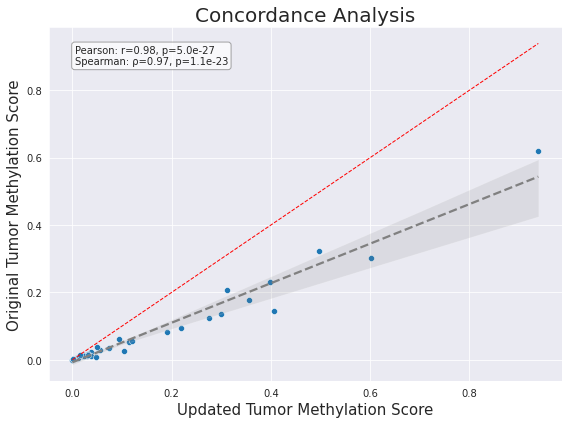

In [20]:
# To NOT flip out the flipped binary call for the sample B00784870. I force the the pred_frac_force to be 0 instead of 0.000022
df_xtx_BIP_150_6 = df_xtx_BIP_150_5.copy()

df_xtx_BIP_150_6.loc[df_xtx_BIP_150_5['GHSampleID'] == "B00784870", 'pred_frac_force'] = 0

# df_xtx_BIP_150_B00784870 = df_xtx_BIP_150_6[df_xtx_BIP_150_6['MB_call'] != df_xtx_BIP_150_6['Tumor_methylation_status']]
# df_xtx_BIP_150_B00784870

analyze_and_plot_correlation(df=df_xtx_BIP_150_6, x_col='pred_frac_force', y_col='Tumor_methylation_score')


In [33]:
df_xtx_BIP_150_6.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,bip_version,runid,fc_dir,MB_score,MB_call,pred_frac_force
39,XTX101-0102-001,NaN,A1124900,B00742781,121-001,Colorectal adenocarcinoma,Stage III,NaN,SUCCESS,NaN,Detected,Detected,0.002037,21.61,4.0,NaN,8/20/24,8/19/24,9/3/24,Sirius-1.5.0-RLS,240824_A00277_1102_AHJTNLDSXC,/ghsfa/ivd/flowcentral/240824_A00277_1102_AHJTNLDSXC/sirius,-6.098045,Detected,0.001957
27,XTX101-0102-001,NaN,A1128224,B00746380,121-002,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.322646,31.54,2.5,NaN,8/22/24,8/21/24,9/3/24,Sirius-1.5.0-RLS,240829_A01361_0739_AHJN5YDSXC,/ghsfa/ivd/flowcentral/240829_A01361_0739_AHJN5YDSXC.a76e5bdd-cabc-4fc2-8b1e-d74e1c10217b.20240831185053/sirius,37.857874,Detected,0.497034
6,XTX101-0102-001,NaN,A1134148,B00751179,101-027,Cecum carcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.015037,18.40,3.0,NaN,8/28/24,8/27/24,9/12/24,Sirius-1.5.0-RLS,240905_A01902_0433_AHKM5WDSXC,/ghsfa/ivd/flowcentral/240905_A01902_0433_AHKM5WDSXC/sirius,16.529713,Detected,0.024000
7,XTX101-0102-001,NaN,A1135200,B00752038,121-004,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.134586,341.06,4.0,NaN,8/29/24,8/28/24,9/12/24,Sirius-1.5.0-RLS,240905_A01902_0433_AHKM5WDSXC,/ghsfa/ivd/flowcentral/240905_A01902_0433_AHKM5WDSXC/sirius,34.393849,Detected,0.298624
8,XTX101-0102-001,NaN,A1136573,B00753130,101-028,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.034691,14.72,4.5,NaN,8/30/24,8/29/24,9/12/24,Sirius-1.5.0-RLS,240906_A01020_0878_BHKGN2DSXC,/ghsfa/ivd/flowcentral/240906_A01020_0878_BHKGN2DSXC/sirius,24.669206,Detected,0.074380


In [37]:
# Final reports to deliver
df_report_final = df_xtx_BIP_150_6.copy()

# Replace the original Tumor_methylation_score with TFv2
df_report_final['Tumor_methylation_score'] = df_report_final['pred_frac_force']
df_report_final = df_report_final.drop(columns=['bip_version', 'runid', 'fc_dir', 'MB_score', 'MB_call', 'pred_frac_force'], errors='ignore')

# Save the data
df_report_final.to_csv(f"{work_dir}/20250117_XilioTherapeutics_reanalysis_39Samples_MonitoringReport.csv", index = False)


df_report_final.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
39,XTX101-0102-001,NaN,A1124900,B00742781,121-001,Colorectal adenocarcinoma,Stage III,NaN,SUCCESS,NaN,Detected,Detected,0.001957,21.61,4.0,NaN,8/20/24,8/19/24,9/3/24
27,XTX101-0102-001,NaN,A1128224,B00746380,121-002,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.497034,31.54,2.5,NaN,8/22/24,8/21/24,9/3/24
6,XTX101-0102-001,NaN,A1134148,B00751179,101-027,Cecum carcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.024000,18.40,3.0,NaN,8/28/24,8/27/24,9/12/24
7,XTX101-0102-001,NaN,A1135200,B00752038,121-004,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.298624,341.06,4.0,NaN,8/29/24,8/28/24,9/12/24
8,XTX101-0102-001,NaN,A1136573,B00753130,101-028,Colorectal adenocarcinoma,"Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type",NaN,SUCCESS,NaN,Detected,Detected,0.074380,14.72,4.5,NaN,8/30/24,8/29/24,9/12/24
